In [6]:
from amm import amm
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
# plt.style.use('paper.mplstyle')

import seaborn as sns
sns.set_theme(style="ticks")

import statsmodels.api as sm
import matplotlib.ticker as mtick
import pickle
import pandas as pd

# Helper functions

In [493]:
def plot_hist(returns, zeta, alpha, q):
    
    sns.kdeplot(returns)
    
    p = np.mean(returns >= zeta)
    var = np.quantile(returns, alpha)
    qtl = np.quantile(returns, 1-q)
    cvar = float(np.sum(returns * (returns <= var)) / np.sum(returns <= var)) / (1 - alpha)

    plt.title(f'$\\zeta$ = {zeta}, $\\alpha$={alpha}, q={q}')
    plt.axvline(var, c='y', linestyle='--', label=f'$VaR={var:4.4}$')
    plt.axvline(cvar, c='r', linestyle='--', label=f'$CVaR={cvar:4.4}$')
    plt.axvline(zeta, c='g', linestyle='--', label=f'$P(r\geq{zeta})={p}$')
    plt.axvline(qtl, c='m', linestyle='--', label=f'$P(r\geq{qtl:.2})={q:.4}$')
    plt.legend()

In [494]:
def plot_2d(returns):
    
    N_assets = returns.shape[1]
    
    fig, ax = plt.subplots(nrows=N_assets, ncols=N_assets, figsize=(2 * N_assets + 2, 2 * N_assets), constrained_layout=True)
    fig.suptitle('2D marginals', fontsize=20)

    for i in range(N_assets):
        for j in range(N_assets):
            if i < j:
                ax[i][j].hist2d(returns[:, i], returns[:, j], bins=50, range=[[-0.3, 0.3], [-0.3, 0.3]], cmap='viridis')
            if i > j:
                fig.delaxes(ax[i][j])

        # kde plot
        sns.kdeplot(data=returns[:, i], ax=ax[i][i], fill=True, label='train')

        # gaussian fit
        xs = np.linspace(np.min(returns[:, i]), np.max(returns[:, i]), 101)
        ys = norm.pdf(xs, loc=np.mean(returns[:, i]), scale=np.std(returns[:, i]))
        ax[i][i].plot(xs, ys, c='r', label='gaussian')

# Generate returns

In [622]:
# N_pools = 6
# params = {'N_pools': N_pools,
#           'Rx0': 100 * np.ones(N_pools),
#           'Ry0': 1000 * np.ones(N_pools),
#           'phi': 0.03 * np.ones(N_pools),
#           'x_0': 10,
#           'alpha': 0.1,
#           'q': 0.75,
#           'zeta': 0.0,
#           'batch_size': 1_000,
#           'kappa': np.array([0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
#           'sigma': np.array([1, 0.3, 0.5, 1.5, 1.75, 2, 2.25]),
#           'p': np.array([0.35, 0.3, 0.34, 0.33, 0.32, 0.31, 0.3]),
#           'T': 60,
#           'seed': 4294967143}

# in this test case return asset0 has lower return, but also lower CVaR
# so without return constraint, one should choose asset0, and as the constraint hits, one should gradually interpolated between 0 and 1

N_pools = 2
params = {'N_pools': N_pools,
          'Rx0': 100 * np.ones(N_pools),
          'Ry0': 1000 * np.ones(N_pools),
          'phi': np.array([0.03, 0.1]),
          'x_0': 10,
          'alpha': 0.05,
          'q': 0.75,
          'zeta': 0.05,
          'batch_size': 1_000,
          'kappa': np.array([0.5, 0.5, 0.5]),
          'sigma': np.array([1., 2., 1.]),
          'p': np.array([0.3, 0.3, 0.3]),
          'T': 60,
          'seed': 4294967143}

# put them into global scope, so that we can call e.g. kappa, instead of params['kappa']
locals().update(params)

In [623]:
pools = amm(Rx=Rx0, Ry=Ry0, phi=phi)

xs_0 = np.repeat(1., N_pools)
l = pools.swap_and_mint(xs_0)
end_pools, Rx_t, Ry_t, v_t, event_type_t, event_direction_t = pools.simulate(kappa, p, sigma, T=T, batch_size=batch_size)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 191.24it/s]


In [624]:
x_T = np.array([pool.burn_and_swap(l) for pool in end_pools])
log_ret = np.log(x_T)
Y = pd.DataFrame(log_ret)
Y

,0,1
0,0.118659,0.143357
1,0.157398,0.063075
2,-0.090767,0.024199
3,0.157814,0.133585
4,0.035729,0.094053
...,...,...
995,0.072388,0.107749
996,0.066889,0.150752
997,0.252204,0.083170
998,0.220343,0.184496


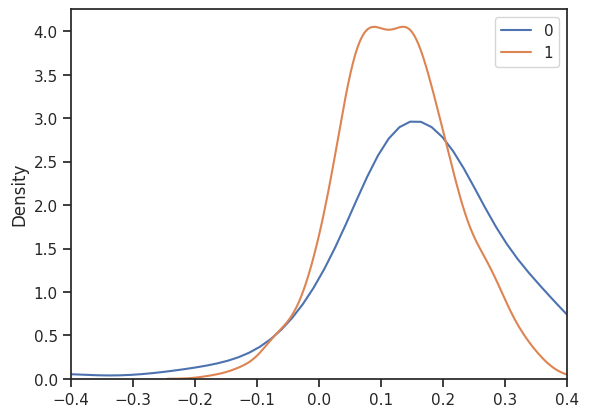

In [625]:
# 1d marginals on top of each other

for i in range(log_ret.shape[1]):
    sns.kdeplot(log_ret[:, i], label=i)
    
plt.xlim((-0.4, 0.4))
plt.legend()

In [626]:
df = pd.DataFrame(log_ret)

print("Mean:")
mean = log_ret.mean(axis=0)
std = log_ret.std(axis=0)
var = np.quantile(log_ret, alpha, axis=0)
cvar = np.sum(log_ret * (log_ret <= var[None, :]), axis=0) / np.sum(log_ret <= var[None, :], axis=0) / (1 - alpha)
emp_cdf = np.mean(log_ret >= zeta, axis=0)
df = pd.DataFrame([mean, std, cvar, emp_cdf], index=['Mean', 'Std', 'Marginal CVaR', f"Empirical CDF @ {zeta}:"])
display(df.style.background_gradient(cmap='coolwarm', axis=1))
# print(f"Correlation matrix:")
# corr = df.corr()
# display(corr.style.background_gradient(cmap='coolwarm', axis=None))

Mean:


,0,1
Mean,0.174982,0.125111
Std,0.194295,0.093292
Marginal CVaR,-0.274559,-0.070692
Empirical CDF @ 0.05:,0.834000,0.797000


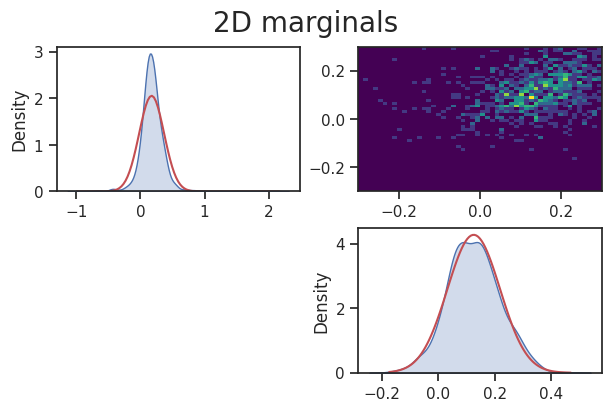

In [628]:
plot_2d(log_ret)

# Average of quantiles vs. quantiles of averages

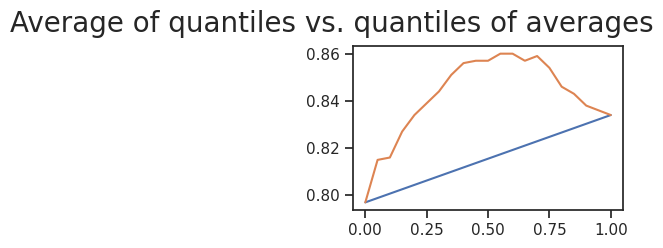

In [629]:
fig, ax = plt.subplots(nrows=N_pools, ncols=N_pools, figsize=(2 * N_pools + 2, 2 * N_pools), constrained_layout=True)
fig.suptitle('Average of quantiles vs. quantiles of averages', fontsize=20)

for i in range(N_pools):
    for j in range(N_pools):
        if i < j:
            q0, q1 = np.mean(log_ret[:, i] >= zeta), np.mean(log_ret[:, j] >= zeta)

            ws = np.linspace(0, 1, 21)
            ps0 = ws * q0 + (1 - ws) * q1
            ps1 = np.mean(ws[:, None] @ log_ret[:, i][None, :] + ((1 - ws[:, None]) @ log_ret[:, j][None, :]) >= zeta, axis=1)

            ax[i][j].plot(ws, ps0)
            ax[i][j].plot(ws, ps1)
            
        if i >= j:
            fig.delaxes(ax[i][j])


# Optimization with riskfolio

In [630]:
import riskfolio as rp
import pandas as pd

Portfolio weights:


,0,1
weights,0.13574,0.86426


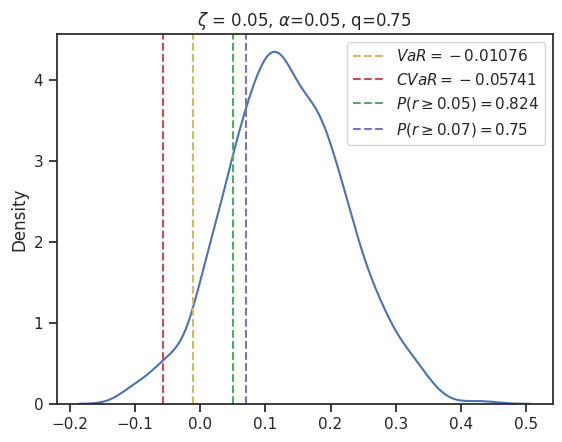

In [631]:
# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'CVaR' # Risk measure used, this time will be variance
obj = 'MinRisk' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

weights = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

print("Portfolio weights:")
display(weights.T)

portfolio_returns = log_ret @ weights
portfolio_returns = portfolio_returns.to_numpy().T[0]
plot_hist(portfolio_returns, zeta=zeta, alpha=alpha, q=q)

# Optimization by hand

1. Adjust code from `riskfolio/src/Portfolio.py`, and incorporate our constraints P(ret >= 0.5) >= 0.7
2. Check if this constraint can be accommodated by riskfolio library

## Linear inequality with second-order constraints

- consider $a^T x \leq b$, with $a \sim \mathcal{N}(\bar{a}, \Sigma)$
- then $a^T x-b \sim \mathcal{N}\left(\bar{a}^T x-b, x^T \Sigma x\right)$
- hence
$$
\operatorname{Prob}\left(a^T x \leq b\right)=\Phi\left(\frac{b-\bar{a}^T x}{\sqrt{x^T \Sigma x}}\right)
$$
- and so
$$
\operatorname{Prob}\left(a^T x \leq b\right) \geq \eta \Longleftrightarrow b-\bar{a}^T x \geq \Phi^{-1}(\eta)\left\|\Sigma^{1 / 2} x\right\|_2
$$
a second-order cone constraint for $\eta \geq 0.5$ (i.e., $\Phi^{-1}(\eta) \geq 0$ )

Objective: 217.51376177236065
Portfolio weights:


,0,1
0,0.869004,0.130996


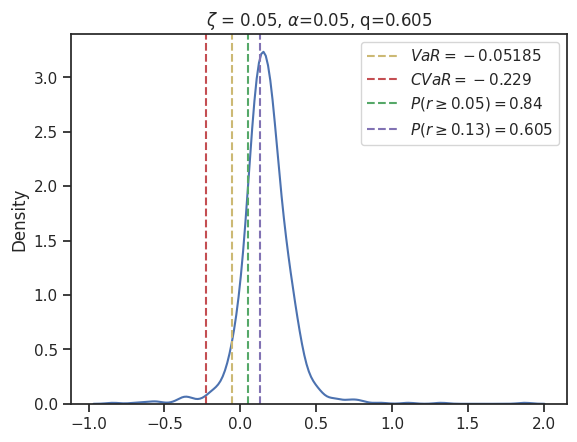

In [666]:
# pseudocode:
# reference file: riskfolio/src/Portfolio.py

import cvxpy as cp
import numpy as np
from scipy.linalg import sqrtm

N_returns, N_assets = returns.shape

weights = cp.Variable((N_assets,))
X = log_ret @ weights

Z = cp.Variable((N_returns,))
var = cp.Variable((1,))
cvar = var + 1 / (alpha * N_returns) * cp.sum(Z)

constraints = [cp.sum(weights) == 1., weights <= 1., weights * 1000 >= 0]

# CVaR constraints
constraints += [Z * 1000 >= 0, Z * 1000 >= -X * 1000 - var * 1000]

# # lower bound: average of emp cdf:
# # might not be a valid constraint! - indeed it's not dominated!
# emp_cdf_005 = np.mean(log_ret >= 0.05, axis=0)
# constraints += [emp_cdf_005 @ weights * 1000 >= q * 1000]

# normal approximation with SOC constraint
mean, cov = log_ret.mean(axis=0), df.cov().to_numpy()
sqrtcov = sqrtm(cov)
constraints += [cp.SOC((-zeta + mean @ weights) / norm.ppf(q), sqrtcov @ weights)]

# # naive idea for the return constraint:
# constraints += [cp.sum(log_ret @ weights >= zeta) >= q * N_returns]

objective = cp.Minimize(cvar * 1000)

# possible solvers: "ECOS", "SCS", "OSQP", "CVXOPT"
prob = cp.Problem(objective, constraints)
result = prob.solve(solver="SCS")

print(f"Objective: {result}")

portfolio_weights = weights.value
portfolio_returns = log_ret @ portfolio_weights

print("Portfolio weights:")
display(pd.DataFrame(portfolio_weights).T)
plot_hist(portfolio_returns, zeta=zeta, alpha=alpha, q=q)

* Comparison table:
    * unconstrained from riskfolio
    * unconstrained our implementation
    * constrained with average of quantiles
    * constrained with Gaussian assumption
* Check how close returns to Gaussian - and can we break it for some values of parameters?
* Try copulas